# Sheet 07

## Preamble

Autors: Marten Ringwelski, Nico Ostermann, Simon Liessem

Note that this notebook MUST be executed in order to get everything to work.
The tasks can't be run individually. 

Also eCampus does not allow for uploading nested directory structures which makes it hard to properly organize the files. The files are expected to be in the `data` directory which itself is placed next to this notebook.

If you extract the zip file we handed in everything should work just fine.

Autoformatting if `jupyter-black` is installed.

In [3]:
try:
    import black
    import jupyter_black

    jupyter_black.load(
        lab=False,
        line_length=79,
        verbosity="DEBUG",
        target_version=black.TargetVersion.PY310,
    )
except ImportError:
    pass

Import all we [nw]eed and more.

Set seaborn default theme

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn.feature_selection import f_classif, SelectKBest
import math as m
import plotly.express as px
import sklearn.manifold
import sklearn.discriminant_analysis
import scipy as sp
import scipy.sparse
import skimage
from dash import Dash, html, dcc, callback, Output, Input, State
from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc
import graphviz
import dash
import logging
import geopandas as gpd

from matplotlib.colors import rgb2hex

Set seaborn default theme

In [5]:
sns.set_theme()

If needed tweak parameters of matplotlib.
Here we increase the size and dpi to bet a bigger but still high-res image.

In [6]:
mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["figure.figsize"] = (20, 15)
%matplotlib inline

Disable future warnings as we get a lot of them and don't really care for this sheet.

In [7]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Exercise 1

In [8]:
gdf = gpd.read_file("data/districts/VG1000_KRS.shp")
gdf = gdf.astype({"AGS_0": "float"})
power_gen = pd.read_csv("data/districts/power_generation.csv")

### a)

<Axes: >

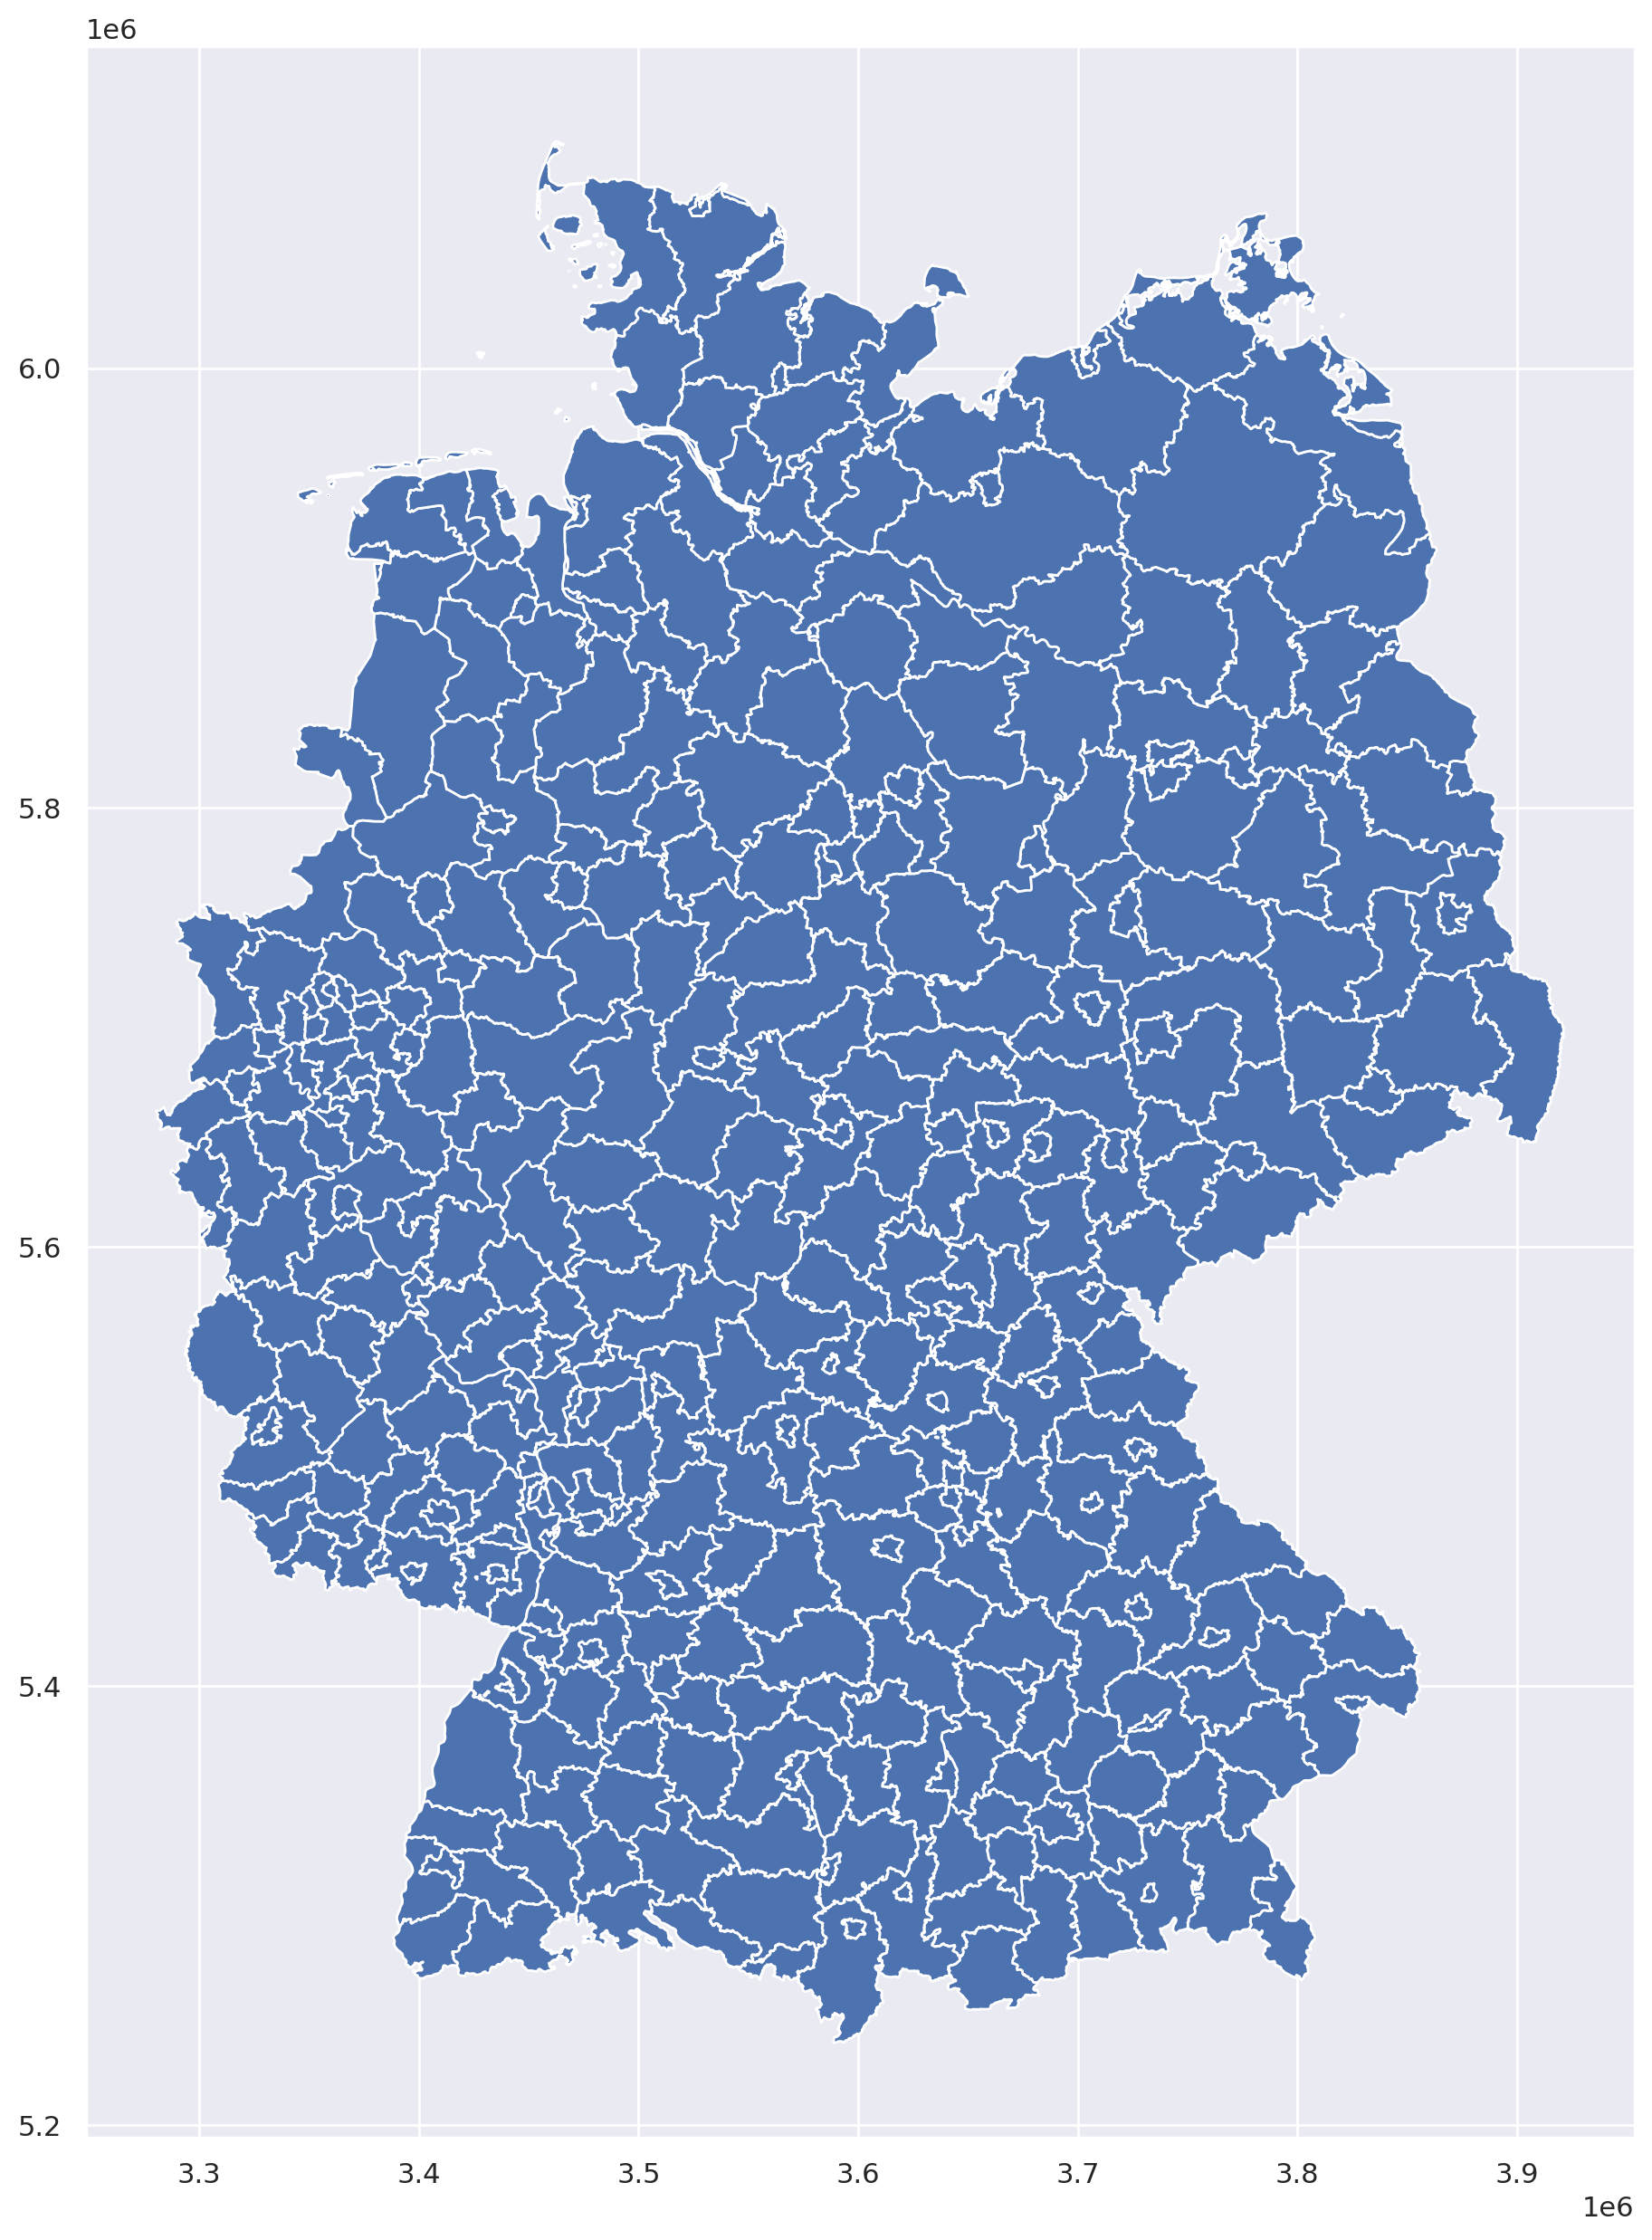

In [9]:
gdf.plot()

### b)

<Axes: >

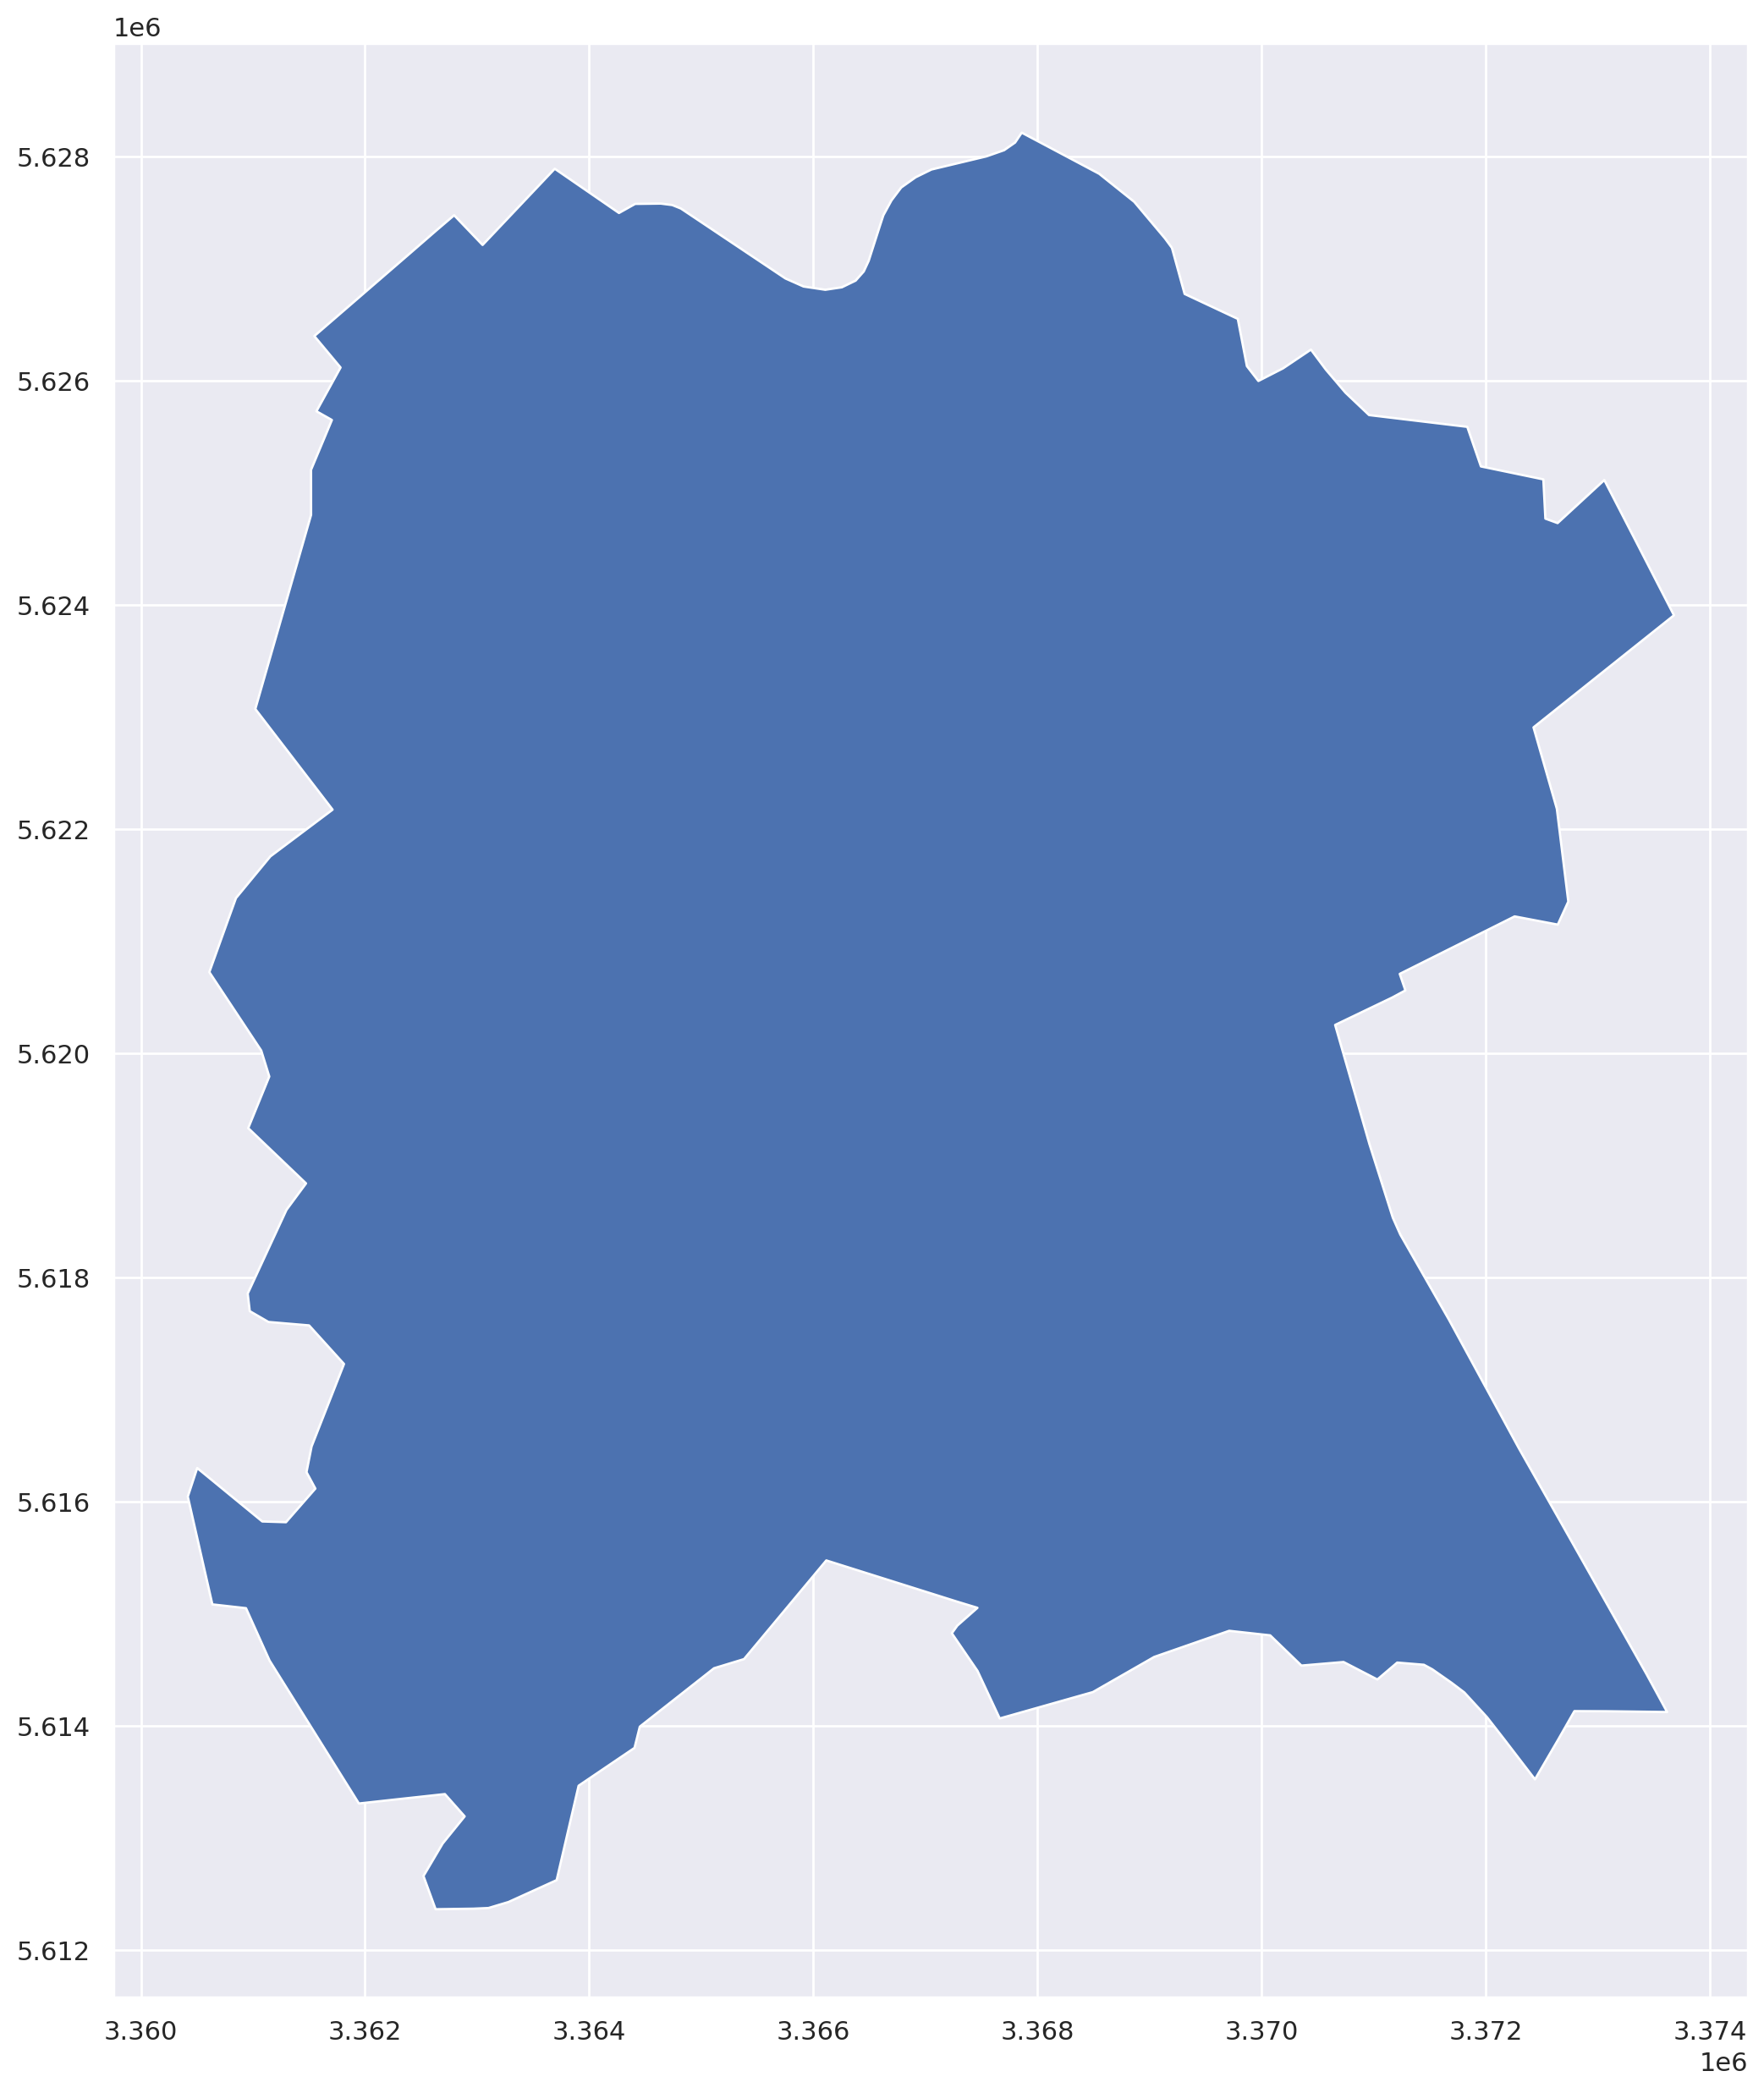

In [10]:
bonn = gdf[gdf["GEN"] == "Bonn"]
bonn.plot()

### c)

In [48]:
accumulated_power = power_gen.groupby(["district", "energyType"]).sum().reset_index()
accumulated_power_wind = accumulated_power[accumulated_power["energyType"] == "wind"]
merged = gdf.merge(accumulated_power_wind[["netRatePower", "district"]], left_on="AGS_0", right_on="district", how="left")

<Axes: >

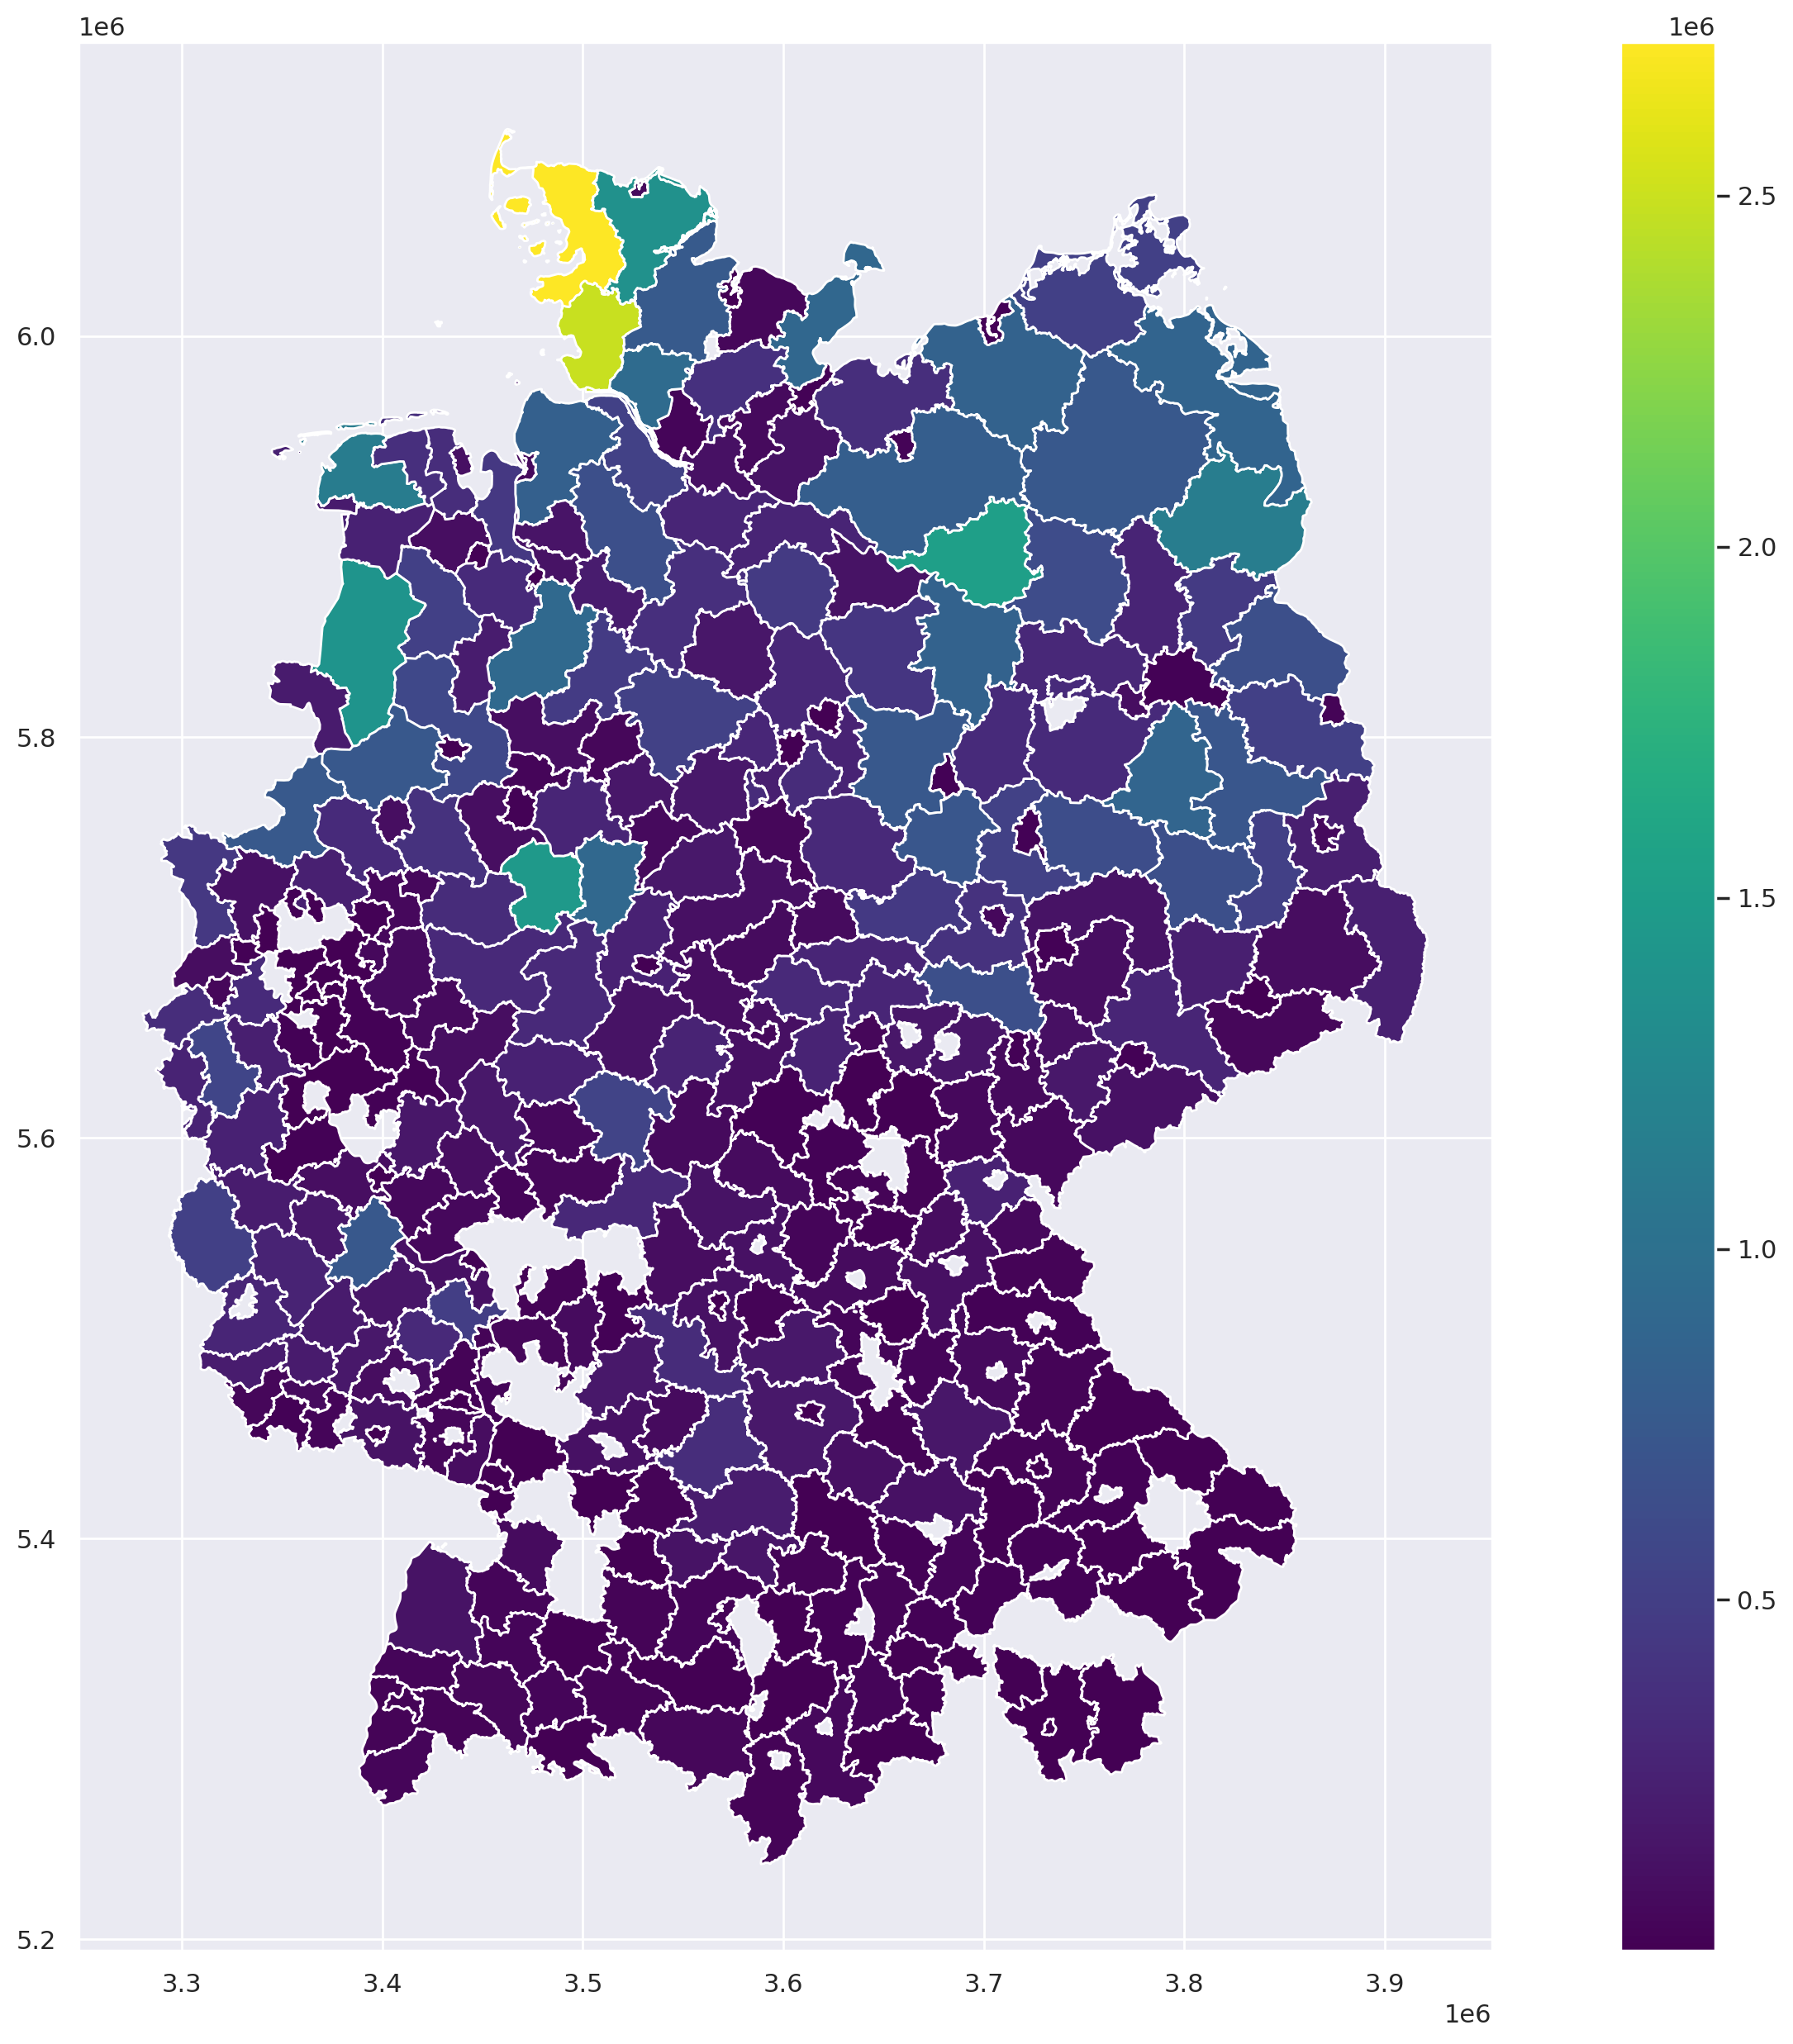

In [47]:
merged.plot(column="netRatePower", cmap="viridis", legend=True)

# Exercise 2

# Exercise 3

### a)

Read data and use mean for missing data.

In [26]:
df = pd.read_excel(
    "data/Data_Cortex_Nuclear.xls",
    index_col="MouseID",
)

Now we do PCA, t-SNE and ISOMAP with parameters that we used in sheet 04.

In [29]:
meta_columns = ["Genotype", "Treatment", "Behavior", "class"]
data_columns = df.columns.difference(meta_columns)
df_wo_meta = df[data_columns]
df_wo_meta = df_wo_meta.fillna(df_wo_meta.mean())

df_scs = df_wo_meta[
    np.logical_or(
        df["class"] == "c-SC-s",
        df["class"] == "t-SC-s",
    )
].copy()

In [30]:
pca = sk.decomposition.PCA(
    n_components=2,
)
# XXX There must be a better way to do this
df_pca = pd.DataFrame(
    pca.fit_transform(df_scs),
    columns=["x", "y"],
    index=df_scs.index,
)
df_pca[df.columns] = df

In [31]:
# We don't care that the calculation is expensive
warnings.simplefilter(
    action="ignore",
    category=sp.sparse.SparseEfficiencyWarning,
)

isomap = sk.manifold.Isomap(
    n_neighbors=20,
)

df_isomap = pd.DataFrame(
    isomap.fit_transform(df_scs),
    columns=["x", "y"],
    index=df_scs.index,
)

df_isomap[df.columns] = df

In [32]:
tsne = sk.manifold.TSNE(
    perplexity=15,
)

df_tsne = pd.DataFrame(
    tsne.fit_transform(df_scs),
    columns=["x", "y"],
    index=df_scs.index,
)

df_tsne[df.columns] = df

Now create the dash app.

In [33]:
# https://dash.plotly.com/workspaces/using-dash-in-jupyter-and-workspaces

In [34]:
app = JupyterDash(__name__)

In [35]:
app.layout = html.Div(
    children=[
        html.Div(
            children=[
                html.Div(
                    children=[
                        # First Graph
                        dcc.RadioItems(
                            ["PCA", "ISOMAP", "t-SNE"],
                            "PCA",
                            id="radio-items-dim-reduction",
                        ),
                        dcc.Graph(
                            figure={},
                            id="graph-dim-reduction",
                        ),
                    ],
                    className="column",
                ),
                html.Div(
                    children=[
                        # Second Graph
                        dcc.Dropdown(
                            data_columns,
                            data_columns[0],
                            id="dropdown-x-axis",
                        ),
                        dcc.Dropdown(
                            data_columns,
                            data_columns[0],
                            id="dropdown-y-axis",
                        ),
                        dcc.Graph(
                            figure={},
                            id="graph-xy",
                        ),
                    ],
                    className="column",
                ),
            ],
            className="row",
        ),
        # Button for adding things
        html.Button(
            "Add",
            id="button-add",
        ),
        # Button for deleting things
        html.Button(
            "Delete slected",
            id="button-del",
        ),
        html.Div(children=[], id="div-user-defined-graphs"),
    ],
)

First add the radio callback as subtask a) asked us to.

In [36]:
@app.callback(
    Output(
        component_id="graph-dim-reduction",
        component_property="figure",
    ),
    Input(
        component_id="radio-items-dim-reduction",
        component_property="value",
    ),
)
def update_graph_dim_reduction(dim_reduction):
    df = None
    if dim_reduction == "PCA":
        df = df_pca
    elif dim_reduction == "ISOMAP":
        df = df_isomap
    elif dim_reduction == "t-SNE":
        df = df_tsne
    else:
        assert False, "Nothing selected"

    fig = px.scatter(
        df,
        x="x",
        y="y",
    )
    return fig

Now add a callback to update the second graph.

In [37]:
@app.callback(
    Output(
        component_id="graph-xy",
        component_property="figure",
    ),
    Input(
        component_id="dropdown-x-axis",
        component_property="value",
    ),
    Input(
        component_id="dropdown-y-axis",
        component_property="value",
    ),
)
def update_graph_xy(x_axis, y_axis):
    assert x_axis is not None, "Nothing selected"
    assert y_axis is not None, "Nothing selected"

    fig = px.scatter(
        df,
        x=x_axis,
        y=y_axis,
    )
    return fig

First define a function to create the div we want to append.

In [38]:
def _create_div(graph: dcc.Graph, graph_id):
    return html.Div(
        children=[
            graph,
            dcc.Checklist(
                id={"type": "user-graph", "index": graph_id},
                options={
                    "label": "",
                },
            ),
        ]
    )

Define functions to update the `div-user-defined-graps`

In [39]:
def _div_user_devined_graphs_add_graph(children, x_axis, y_axis):
    assert x_axis is not None, "Nothing selected"
    assert y_axis is not None, "Nothing selected"

    # Probably we should copy the figure rather than recreate it. Anyways..
    fig = px.scatter(
        df,
        x=x_axis,
        y=y_axis,
    )
    graph = dcc.Graph(figure=fig)
    # XXX This could cause duplicated ids
    div = _create_div(graph, graph_id=f"{x_axis}-{y_axis}")
    children.append(div)
    return children

In [40]:
def _div_user_devined_graphs_del_graph(children, checklists_value):
    # Iterate backwards to be able to remove by index
    for i, value in reversed(list(enumerate(checklists_value))):
        # Using checklists with one element for a checkbox is a bit hacky..
        checked = value is not None and len(value) == 1
        if not checked:
            continue
        children.pop(i)

    return children

Now define the callback for the button.

In [41]:
@app.callback(
    Output(
        component_id="div-user-defined-graphs",
        component_property="children",
    ),
    Input("button-add", "n_clicks"),
    Input("button-del", "n_clicks"),
    State(
        component_id="dropdown-x-axis",
        component_property="value",
    ),
    State(
        component_id="dropdown-y-axis",
        component_property="value",
    ),
    State(
        component_id="div-user-defined-graphs",
        component_property="children",
    ),
    State(
        component_id={"type": "user-graph", "index": dash.ALL},
        component_property="value",
    ),
    # We don't want to show a graph when the user didn't click.
    prevent_initial_call=True,
)
def update_div_user_defined_graphs(
    button_add,
    button_del,
    dropdown_x_axis,
    dropdown_y_axis,
    div_user_defined_graphs,
    checklists_user_graph,
):
    del button_add
    del button_del
    # Can't we have a cleaner way to have this many inputs/states?!
    x_axis = dropdown_x_axis
    y_axis = dropdown_y_axis
    children = div_user_defined_graphs
    checklists_value = checklists_user_graph

    trigger = dash.ctx.triggered_id
    if trigger == "button-add":
        return _div_user_devined_graphs_add_graph(children, x_axis, y_axis)
    elif trigger == "button-del":
        return _div_user_devined_graphs_del_graph(children, checklists_value)
    else:
        assert False

Define the callback to delete selected graphs.

Now run the thing.

In [42]:
if __name__ == "__main__":
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/


### b)

It made sense to combine all tasks in one so please have a look at a) for all solutions for a), b) and c).

### c)

It made sense to combine all tasks in one so please have a look at a) for all solutions for a), b) and c).